In [1]:
import re
import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS



In [2]:
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv").fillna(' ')
train_df.head()

,id,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [3]:
train_df.describe()

,id,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,9.024365e+05,1.030173e-01,4.582099e-03,1.387721e-02,9.311271e-03,8.115273e-02,2.263571e-02,6.605974e-03
std,5.210224e+05,1.970757e-01,2.286128e-02,6.460419e-02,4.942218e-02,1.760657e-01,7.873156e-02,4.529782e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.512182e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.024365e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.353655e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00
max,1.804873e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv").fillna(' ') #fill missing values with space
test_df.head(10)

,id,text
0,0,[ Integrity means that you pay your debts.]\n\...
1,1,This is malfeasance by the Administrator and t...
2,2,@Rmiller101 - Spoken like a true elitist. But ...
3,3,"Paul: Thank you for your kind words. I do, in..."
4,4,Sorry you missed high school. Eisenhower sent ...
5,5,Let’s see if I understand this; Berkowitz anno...
6,6,Our oils read; President IS taking different ...
7,7,'Work together'? Dream on. The liberals are al...
8,8,What would Jerry Prevo think about that story?...
9,9,When wil the indigenous be accountable and t...


In [5]:
test_df.describe()

,id
count,97320.000000
mean,48659.500000
std,28094.008436
min,0.000000
25%,24329.750000
50%,48659.500000
75%,72989.250000
max,97319.000000


In [6]:
test_df.info

<bound method DataFrame.info of           id                                               text
0          0  [ Integrity means that you pay your debts.]\n\...
1          1  This is malfeasance by the Administrator and t...
2          2  @Rmiller101 - Spoken like a true elitist. But ...
3          3  Paul: Thank you for your kind words.  I do, in...
4          4  Sorry you missed high school. Eisenhower sent ...
...      ...                                                ...
97315  97315  He should lose his job for promoting mis-infor...
97316  97316  "Thinning project is meant to lower fire dange...
97317  97317  I hope you millennials are happy that you put ...
97318  97318  I'm thinking Kellyanne Conway (a.k.a. The Trum...
97319  97319  I still can't figure why a pizza in AK cost mo...

[97320 rows x 2 columns]>

In [7]:
print("Training data shape: ",train_df.shape)
print("Testing data shape: ",test_df.shape)

Training data shape:  (1804874, 9)
Testing data shape:  (97320, 2)


In [8]:
train_df  = train_df.drop(['id'],axis = 1)
test_df   = test_df.drop(['id'],axis = 1)

In [9]:
null_tr = train_df.isnull().sum()
print("Null values in training set: ")
print(null_tr)
print()
null_test = test_df.isnull().sum()
print("Null values in testing set: ")
print( null_test)
print()

Null values in training set: 
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

Null values in testing set: 
text    0
dtype: int64



In [10]:
def clean_text(line):

    clean_t = ""
    line = line.replace("’", "")  #replace these symbols with spaces(" ") or no space("")
    line = line.replace("'", "")
    line = line.replace("=", "")
    line = line.replace("-", " ")
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'zxcvbnmlkjhgfdsaqwertyuiop ':
            clean_t += char
        else:
            clean_t += ' '

    clean_t = re.sub(' +',' ',clean_t) #delete extra spaces

    return clean_t

In [11]:
# clean text
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text']  = test_df['text'].apply(lambda x: clean_text(x))

In [12]:
x = train_df["text"].values
print(x)

['this is so cool its like would you want your mother to read this really great idea well done '
 'thank you this would make my life a lot less anxiety inducing keep it up and dont let anyone get in your way '
 'this is such an urgent design problem kudos to you for taking it on very impressive '
 ... 'thank you right or wrong i am following your advice'
 'anyone who is quoted as having the following exchange even if apocryphal would have received my vote bessie braddock winston you are drunk and whats more you are disgustingly drunk winston churchill bessie my dear you are ugly and whats more you are disgustingly ugly but tomorrow i shall be sober and you will still be disgustingly ugly '
 'students defined as ebd are legally just as disabled and eligible for special services as a developmentally disabled or physically disabled student emotional and behavioral disorder ebd definition an emotional and behavioral disorder is an emotional disability characterized by the following i an in

In [13]:
list_class = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack","sexual_explicit"]
y = train_df[list_class].values
print(y)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.6212121  0.03030303 0.03030303 ... 0.6212121  0.04545455 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
x_test = test_df['text'].values
print(x_test)

[' integrity means that you pay your debts does this apply to president trump too '
 'this is malfeasance by the administrator and the board they are wasting our money '
 ' rmiller spoken like a true elitist but look out bud the re awakening in europe brexit and now the trump victory are just the beginning the unwashed masses are coming for you and your ilk '
 ...
 'i hope you millennials are happy that you put this airhead in charge '
 'im thinking kellyanne conway a k a the trump whisperer will play a very large role in the trump administration and as crazy as this sounds that might be a good thing '
 'i still cant figure why a pizza in ak cost more than a pizza in washington idaho kentucky etc etc the only answer i get is shipping charges i guess costco does not incur a shipping charge because there is no price difference if i am going to be charged extra at least the tv commercials for ak should show the actual prices i sure as heck dont make anymore income here than i do in wa soc

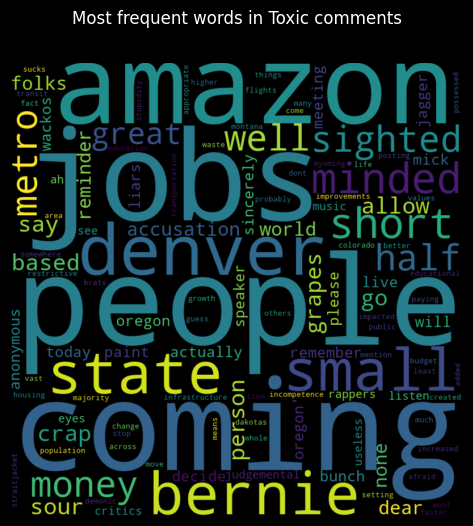

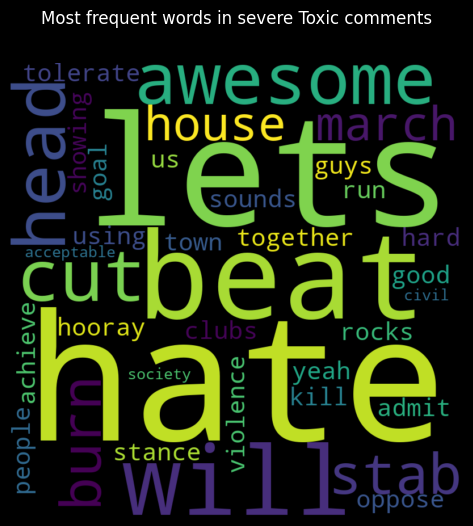

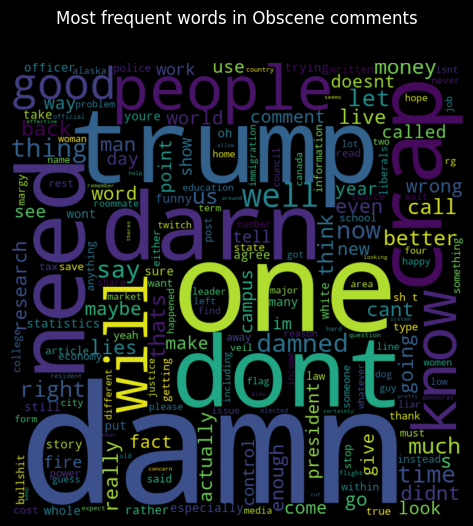

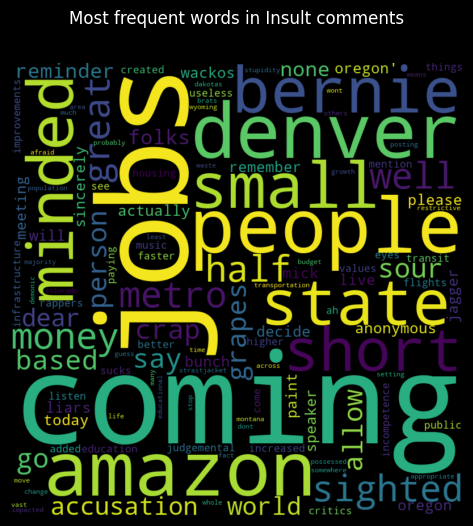

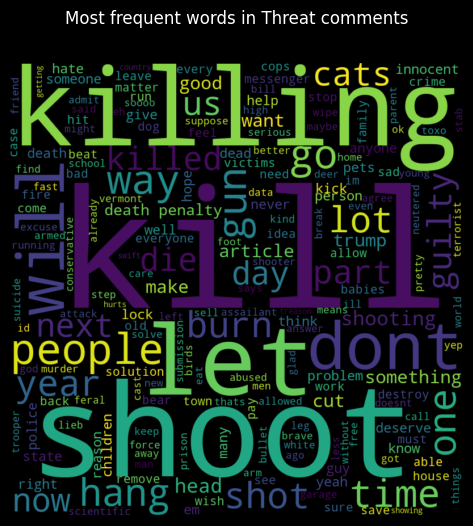

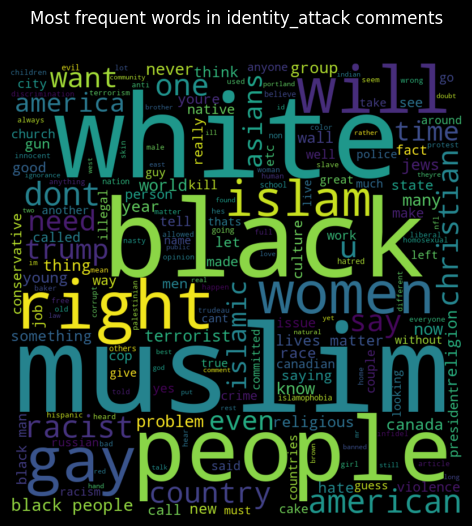

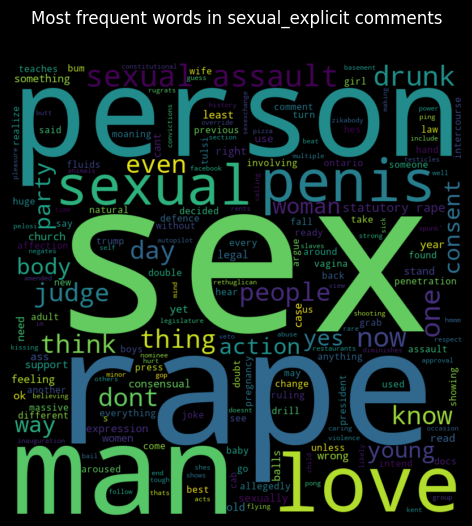

In [15]:
def word_plot(column,text):
    
    comments = train_df['text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 800, height = 800,
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxicity'], "Toxic comments")
word_plot(train_df['severe_toxicity'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")
word_plot(train_df['identity_attack'],"identity_attack comments")
word_plot(train_df['sexual_explicit'],"sexual_explicit comments")

In [16]:
#Count words
count_word = train_df["text"].apply(lambda x: len(str(x).split()))

#Unique word count
count_unique_word = train_df["text"].apply(lambda x: len(set(str(x).split())))

In [17]:
unique_percent = count_unique_word*100/count_word
unique_percent

0           94.736842
1          100.000000
2          100.000000
3           94.117647
4          100.000000
              ...    
1804869     86.486486
1804870    100.000000
1804871    100.000000
1804872     65.517241
1804873     71.755725
Name: text, Length: 1804874, dtype: float64

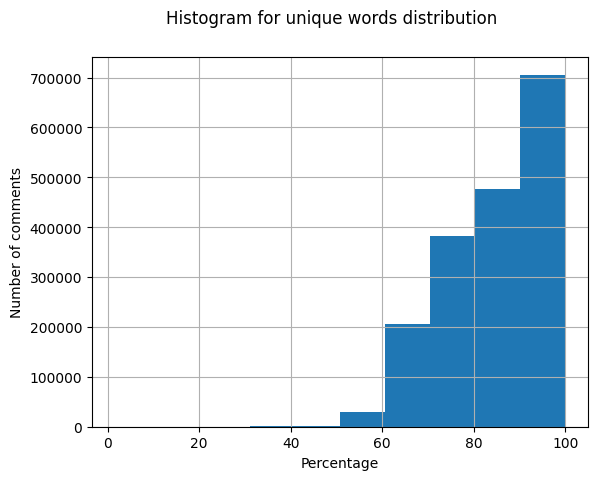

In [18]:
unique_percent.hist()
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

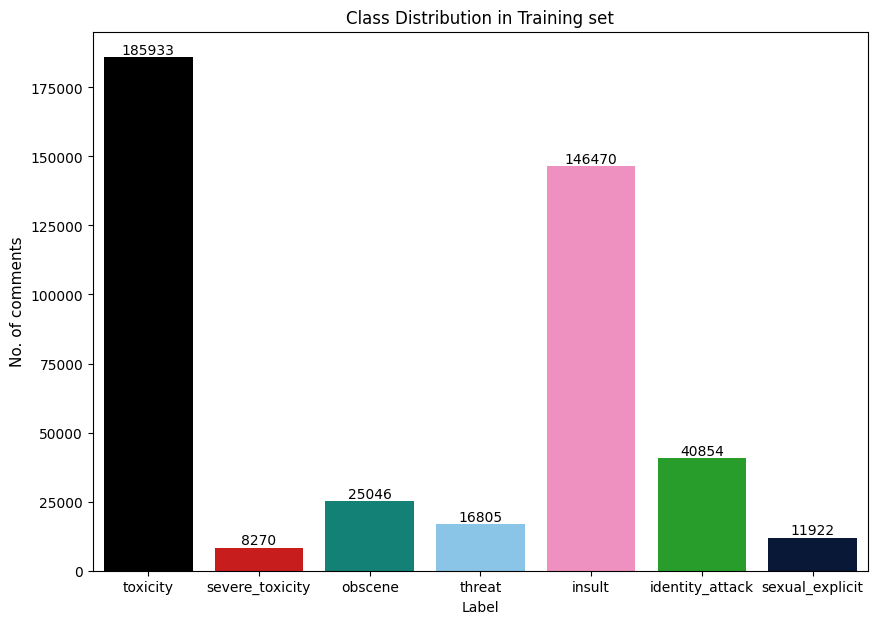

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


colors_ = ["black", "red", "teal", "lightblue", "pink", "green", "navy"]
palette = sns.xkcd_palette(colors_)

x = train_df.iloc[:, 1:].sum()

# Create a bar plot
plt.figure(figsize=(10,7))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)

# Set plot title and labels
plt.title("Class Distribution in Training set")
plt.xlabel('Label')
plt.ylabel('No. of comments', fontsize=11)

# Add the value labels on top of the bars
patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    # Place the labels a little above the top of each bar to avoid overlap
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, int(label), va='bottom', ha='center')

# Display the plot
plt.show()


/tmp/ipykernel_23/2635369167.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


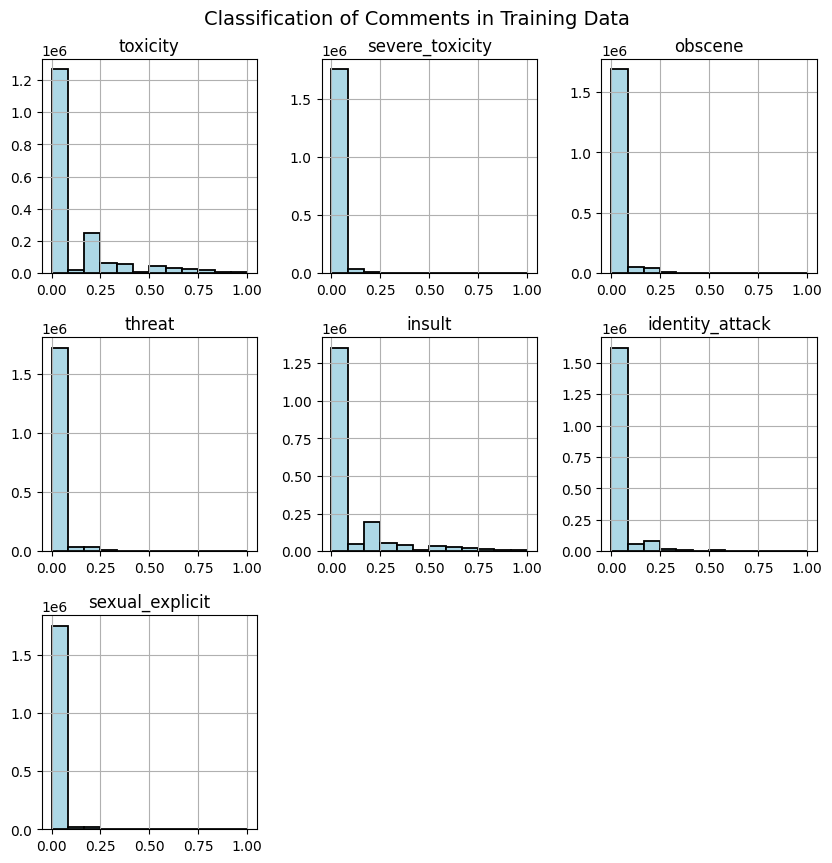

In [20]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

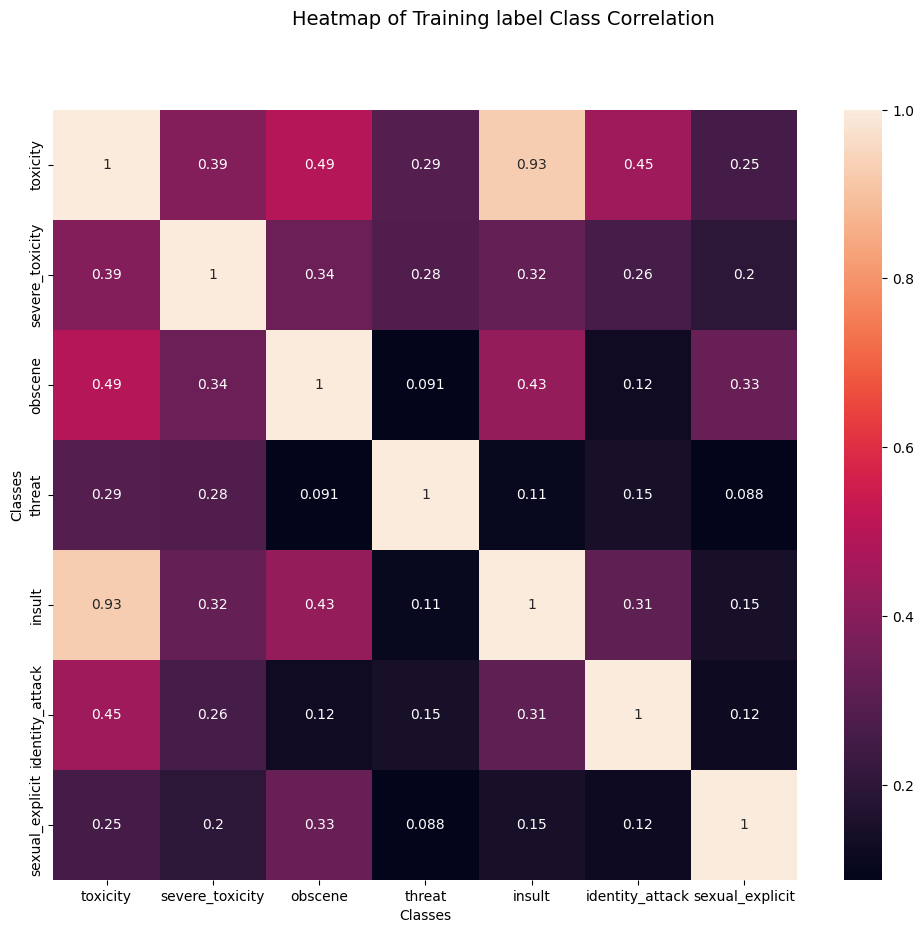

In [21]:
train_df_no_text = train_df.drop(columns=['text'])

fig = plt.figure(figsize = (12,10))
sns.heatmap(train_df_no_text.corr(), annot=True)
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [22]:
x=train_df['text']

In [23]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict

# Constants
MAX_FEATURES = 30000  # Limit to top 30,000 frequent words in the dataset
MAX_TEXT_LENGTH = 400  # Maximum length of input text after padding
EMBEDDING_DIM = 300  # Dimensionality of word embeddings

# Tokenization and text padding
def tokenize_and_pad_texts(text_data, word_to_index, tokenizer, max_len=MAX_TEXT_LENGTH):
    """Tokenizes and pads the input text data."""
    # Convert tokens to indices
    tokenized_data = [
        [word_to_index.get(token, 0) for token in tokenizer(text)[:max_len]]
        for text in text_data
    ]
    
    # Convert to tensor
    tokenized_data = [torch.tensor(tokens) for tokens in tokenized_data]
    
    # Pad sequences
    return pad_sequence(tokenized_data, batch_first=True, padding_value=0)

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path, embedding_dim=EMBEDDING_DIM):
    """Loads GloVe embeddings into a dictionary."""
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    return embeddings_index

# Create embedding matrix
def create_embedding_matrix(word_to_index, embeddings_index, max_features=MAX_FEATURES, embedding_dim=EMBEDDING_DIM):
    """Creates an embedding matrix where each word index is mapped to its GloVe vector."""
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, index in word_to_index.items():
        if index >= max_features:
            break
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return torch.tensor(embedding_matrix, dtype=torch.float)

# Main pipeline
def prepare_data_for_training(x_train, x_test, glove_file_path, tokenizer):
    """Prepares tokenized and padded data and the corresponding embedding matrix."""
    # Build vocabulary and word-to-index mapping
    word_counts = defaultdict(int)
    for text in x_train:
        for word in tokenizer(text):
            word_counts[word] += 1
    
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    word_to_index = {word: i + 1 for i, word in enumerate(sorted_vocab[:MAX_FEATURES - 1])}
    word_to_index['<UNK>'] = 0  # Add unknown token
    
    # Load GloVe embeddings and create embedding matrix
    embeddings_index = load_glove_embeddings(glove_file_path)
    embedding_matrix = create_embedding_matrix(word_to_index, embeddings_index)
    
    # Tokenize and pad training and testing data
    x_train_padded = tokenize_and_pad_texts(x_train, word_to_index, tokenizer)
    x_test_padded = tokenize_and_pad_texts(x_test, word_to_index, tokenizer)
    
    return x_train_padded, x_test_padded, embedding_matrix, word_to_index

# Example tokenizer function
def example_tokenizer(text):
    return text.lower().split()  # Simple space-based tokenizer for illustration

# Usage example (you'll need to provide x and x_test):
# x_train_padded, x_test_padded, embedding_matrix, word_to_index = prepare_data_for_training(
#     x, x_test, '/path/to/glove/embeddings.txt', example_tokenizer
# )

In [24]:
max_features = 30000 # most freq 20k words in the dataset would be kept
max_text_length = 400

In [25]:
from collections import defaultdict
import torch
from torch.nn.utils.rnn import pad_sequence

# Constants
MAX_FEATURES = 30000  # Limit to top 30,000 frequent words in the dataset
MAX_TEXT_LENGTH = 400  # Maximum length of input text after padding

# Tokenizer function to build vocabulary and tokenize texts
def build_vocab_and_tokenize(texts, max_features):
    """Builds a vocabulary and tokenizes texts into sequences of integers."""
    word_counts = defaultdict(int)
    for text in texts:
        for word in text.split():  # Simple whitespace tokenizer
            word_counts[word] += 1

    # Create a sorted vocabulary (by frequency) with max_features limit
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)[:max_features - 1]
    word_to_index = {word: idx + 1 for idx, word in enumerate(sorted_vocab)}  # Index starts at 1 (0 for padding)

    # Tokenize texts into sequences of integers
    tokenized_texts = [
        torch.tensor([word_to_index.get(word, 0) for word in text.split()], dtype=torch.long)
        for text in texts
    ]
    return word_to_index, tokenized_texts

# Padding function for tokenized sequences
def pad_tokenized_sequences(tokenized_texts, max_len=MAX_TEXT_LENGTH):
    """Pads sequences of tokenized texts to a fixed length."""
    tokenized_texts = [seq[:max_len] for seq in tokenized_texts]  # Truncate if longer than max_len
    return pad_sequence(tokenized_texts, batch_first=True, padding_value=0)  # Pad with 0

# Usage
word_to_index, x_tokenized = build_vocab_and_tokenize(x, MAX_FEATURES)
x_train_val = pad_tokenized_sequences(x_tokenized, MAX_TEXT_LENGTH)


In [26]:
# Tokenize the test data using the existing vocabulary
def tokenize_texts_with_vocab(texts, word_to_index):
    """Tokenizes texts into sequences of integers using an existing vocabulary."""
    tokenized_texts = [
        torch.tensor([word_to_index.get(word, 0) for word in text.split()], dtype=torch.long)
        for text in texts
    ]
    return tokenized_texts

# Tokenize and pad the test dataset
x_test_tokenized = tokenize_texts_with_vocab(x_test, word_to_index)
x_testing = pad_tokenized_sequences(x_test_tokenized, MAX_TEXT_LENGTH)


In [27]:
import torch

embedding_dim = 300
embeddings_index = {}

# Open the GloVe file with UTF-8 encoding
with open('/kaggle/input/glove300/glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)  # Store as PyTorch tensor
        embeddings_index[word] = coefs  # Populate embedding dict

print(f'Found {len(embeddings_index)} word vectors.')


Found 1917494 word vectors.


In [28]:
import torch

# Initialize the embedding matrix with zeros
embedding_matrix = torch.zeros((MAX_FEATURES, EMBEDDING_DIM), dtype=torch.float32)

# Populate the embedding matrix
for word, index in word_to_index.items():
    if index >= MAX_FEATURES:  # Limit to MAX_FEATURES
        continue
    embedding_vector = embeddings_index.get(word)  # Retrieve GloVe embedding for the word
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector  # Assign to the embedding matrix


In [29]:
import torch
from collections import defaultdict

# Define your training data (x_train) from your dataset
x_train = train_df['text'].values  # Assuming train_df is the DataFrame with 'text' column

# Build the vocabulary and tokenize training data
def build_vocab_and_tokenize(texts, max_features):
    """Builds a vocabulary and tokenizes texts into sequences of integers."""
    word_counts = defaultdict(int)
    for text in texts:
        for word in text.split():  # Simple whitespace tokenizer
            word_counts[word] += 1

    # Create a sorted vocabulary (by frequency) with max_features limit
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)[:max_features - 1]
    word_to_index = {word: idx + 1 for idx, word in enumerate(sorted_vocab)}  # Index starts at 1 (0 for padding)

    # Tokenize texts into sequences of integers
    tokenized_texts = [
        torch.tensor([word_to_index.get(word, 0) for word in text.split()], dtype=torch.long)
        for text in texts
    ]
    return word_to_index, tokenized_texts

# Build the vocabulary and tokenize the training data
word_to_index, x_tokenized = build_vocab_and_tokenize(x_train, MAX_FEATURES)

# Initialize the embedding matrix with zeros
embedding_matrix = torch.zeros((MAX_FEATURES, EMBEDDING_DIM), dtype=torch.float32)

# Populate the embedding matrix
for word, index in word_to_index.items():
    if index >= MAX_FEATURES:  # Bounding by max features
        continue
    
    # Get the corresponding word embedding from the GloVe embeddings
    embedding_vector = embeddings_index.get(word)
    
    # If the word has an embedding vector, add it to the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[index] = torch.tensor(embedding_vector, dtype=torch.float32)


/tmp/ipykernel_23/789180390.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_matrix[index] = torch.tensor(embedding_vector, dtype=torch.float32)


In [30]:
print(embedding_matrix)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2084, -0.1493, -0.0175,  ..., -0.5407,  0.2120, -0.0094],
        [-0.2484, -0.4546,  0.0392,  ...,  0.0531,  0.1546, -0.3805],
        ...,
        [-0.6699, -0.1543,  0.0833,  ..., -0.1504, -0.1607, -0.1159],
        [ 1.0728, -0.7147,  0.1627,  ..., -0.4596,  0.0490,  0.3044],
        [-0.0710,  0.1134,  0.0943,  ..., -0.1606,  0.2051, -0.4682]])


In [31]:
embedding_matrix.shape

torch.Size([30000, 300])

In [32]:
from torch.nn.utils.rnn import pad_sequence

# Function to pad tokenized sequences
def pad_tokenized_sequences(tokenized_texts, max_len=MAX_TEXT_LENGTH):
    """Pads tokenized sequences to a fixed length."""
    # Truncate sequences longer than max_len
    tokenized_texts = [seq[:max_len] for seq in tokenized_texts]
    
    # Pad sequences to the same length
    return pad_sequence(tokenized_texts, batch_first=True, padding_value=0)

# Pad the tokenized training data
x_train_val = pad_tokenized_sequences(x_tokenized, MAX_TEXT_LENGTH)
x_train_val


tensor([[  18,    6,   33,  ...,    0,    0,    0],
        [ 404,   10,   18,  ...,    0,    0,    0],
        [  18,    6,  151,  ...,    0,    0,    0],
        ...,
        [ 404,   10,   84,  ...,    0,    0,    0],
        [ 203,   37,    6,  ...,    0,    0,    0],
        [ 645, 2572,   21,  ...,    0,    0,    0]])

In [33]:
print(x_train_val.shape, y.shape)

torch.Size([1804874, 320]) (1804874, 7)


In [34]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y,
                                              test_size = 0.2,
                                              shuffle = True,
                                              random_state = 1)

In [35]:
print("Training Data Shape: ")
print(x_train.shape, y_train.shape)

Training Data Shape: 
torch.Size([1443899, 320]) (1443899, 7)


In [36]:
print("Validation Data Shape: ")
print(x_val.shape, y_val.shape)

Validation Data Shape: 
torch.Size([360975, 320]) (360975, 7)


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Parameter settings
filters = 250
kernel_size = 3
hidden_dims = 250
batch_size = 32
n_epochs = 1
drop_rate = 0.4
learning_rate = 0.01

# PyTorch Model Definition
class TextClassifier(nn.Module):
    def __init__(self, embedding_matrix, max_features, embedding_dim, output_classes=7):
        super(TextClassifier, self).__init__()
        
        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True  # Non-trainable embeddings
        )
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(embedding_dim, filters, kernel_size=3, padding=0)
        self.conv2 = nn.Conv1d(filters, filters, kernel_size=5, padding=0)
        
        # Pooling layers
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(filters, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, output_classes)
        
        # Dropout
        self.dropout = nn.Dropout(drop_rate)
    
    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)  # (batch_size, max_len, embedding_dim)
        
        # Conv1D expects input of shape (batch_size, channels, seq_length)
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, embedding_dim, max_len)
        
        # First convolutional layer + MaxPooling
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        # Second convolutional layer + Global MaxPooling
        x = F.relu(self.conv2(x))
        x = self.global_maxpool(x).squeeze(2)  # Squeeze last dimension
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Sigmoid activation for multi-label classification
        return torch.sigmoid(x)

# Instantiate the model
model = TextClassifier(
    embedding_matrix=embedding_matrix, 
    max_features=MAX_FEATURES, 
    embedding_dim=EMBEDDING_DIM, 
    output_classes=7
)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification

# Summary of the model
print(model)


/tmp/ipykernel_23/3850835210.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),


TextClassifier(
  (embedding): Embedding(30000, 300)
  (conv1): Conv1d(300, 250, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(250, 250, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_maxpool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=250, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=7, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [38]:

import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Assuming x_train, y_train, x_val, y_val are numpy arrays
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)  # Convert to PyTorch tensor and move to GPU
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)  # Multi-label targets

x_val_tensor = torch.tensor(x_val, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Create DataLoader for training and validation
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training function with additional metrics and progress bar
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device, model_save_path="model.pth"):
    model.to(device)  # Move the model to GPU
    
    for epoch in range(n_epochs):
        model.train()  # Set to training mode
        train_loss = 0.0
        train_accuracy = 0.0  # Track accuracy for the epoch

        # Training loop with progress bar
        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Zero gradients
            outputs = model(x_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            train_loss += loss.item()

            # Calculate accuracy
            preds = (outputs > 0.5).float()  # Binarize predictions
            correct = (preds == y_batch).float().sum()
            accuracy = correct / y_batch.size(0)
            train_accuracy += accuracy.item()

        # Validation step
        model.eval()  # Set to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batch to GPU
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                # Calculate validation accuracy
                preds = (outputs > 0.5).float()
                correct = (preds == y_batch).float().sum()
                accuracy = correct / y_batch.size(0)
                val_accuracy += accuracy.item()

        # Print epoch stats
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Train Accuracy: {train_accuracy/len(train_loader):.4f} - Val Loss: {val_loss/len(val_loader):.4f} - Val Accuracy: {val_accuracy/len(val_loader):.4f}")

        # Save the model after each epoch (optional, save after each epoch)
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

    # Final model save (optional)
    torch.save(model.state_dict(), model_save_path)
    print(f"Final model saved to {model_save_path}")

# Train the model
train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device)


Using device: cuda


/tmp/ipykernel_23/3036652580.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)  # Convert to PyTorch tensor and move to GPU
/tmp/ipykernel_23/3036652580.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long).to(device)
Epoch 1: 100%|███████████████████████████████████████████████| 45122/45122 [04:32<00:00, 165.84it/s]


Epoch 1/1 - Train Loss: 0.1285 - Train Accuracy: 6.0878 - Val Loss: 0.1094 - Val Accuracy: 6.0953
Model saved to model.pth
Final model saved to model.pth


In [39]:
# import torch
# import pandas as pd
# from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm

# # Assuming the model is already trained and saved
# # Load the trained model
# model = TextCNN(vocab_size=5000, embedding_dim=300, num_filters=128, filter_sizes=[3, 4, 5], num_classes=7)
# model.load_state_dict(torch.load('model.pth'))
# model.eval()

# # Check if CUDA (GPU) is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")
# model.to(device)  # Move model to the appropriate device

# # Inference Dataset Class
# class TextDataset(Dataset):
#     def __init__(self, text_data, tokenizer):
#         self.text_data = text_data
#         self.tokenizer = tokenizer
        
#     def __len__(self):
#         return len(self.text_data)
    
#     def __getitem__(self, idx):
#         text = self.text_data[idx]
#         tokenized_text = self.tokenizer(text)  # Assume tokenizer returns tokenized indices
#         return torch.tensor(tokenized_text)

# # Example tokenizer function (you should replace it with your actual tokenizer)
# def tokenizer(text):
#     return [ord(c) for c in text]  # Simple tokenization (replace with a real tokenizer)

# # Load the test dataset
# test_df = pd.read_csv('test.csv')  # Ensure 'test.csv' is the path to your test file
# test_texts = test_df['text_column_name'].tolist()  # Replace 'text_column_name' with the actual column name in your CSV

# # Tokenize the test data
# test_dataset = TextDataset(test_texts, tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Inference function
# def inference_loop(model, test_loader, device):
#     model.eval()  # Set model to evaluation mode
#     all_predictions = []

#     with torch.no_grad():  # Disable gradient calculation during inference
#         for batch in tqdm(test_loader, desc="Inference", ncols=100):
#             batch = batch.to(device)  # Move batch to device
#             outputs = model(batch)  # Forward pass through the model
#             predictions = (outputs > 0.5).float()  # Binarize the predictions (multi-label classification)
#             all_predictions.extend(predictions.cpu().numpy())  # Move predictions to CPU and store them

#     return all_predictions

# # Make predictions
# predictions = inference_loop(model, test_loader, device)

# # Map the predictions to column names
# label_mapping = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit']

# # Create a DataFrame for submission
# submission_df = test_df[['id']].copy()  # Assuming 'id' column exists in test.csv
# submission_df[label_mapping] = predictions

# # Save the predictions to a CSV file
# submission_df.to_csv('submission.csv', index=False)

# print("Predictions saved to 'submission.csv'")





















In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():  # No gradient computation during evaluation
        for x_batch, y_batch in val_loader:
            # Move the data to the same device as the model
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            outputs = model(x_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            val_loss += loss.item()

            # Compute accuracy (binary classification)
            preds = (outputs > 0.5).float()  # Apply threshold of 0.5 to get binary predictions
            correct_preds += (preds == y_batch).sum().item()
            total_preds += y_batch.size(0) * y_batch.size(1)  # Count total predictions

    avg_loss = val_loss / len(val_loader)
    accuracy = correct_preds / total_preds

    return avg_loss, accuracy

# Assuming the criterion (loss function) is defined as well
# For example, using BCEWithLogitsLoss for multi-label classification
criterion = torch.nn.BCEWithLogitsLoss()

# Evaluate the model on validation data
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Using device: cuda
Validation Loss: 0.7036, Validation Accuracy: 0.8708


In [41]:
from torch.utils.data import DataLoader, Dataset
# Load the pre-trained model and embeddings (replace with actual paths)
device = torch.device('cpu')  # Set device for inference
model = TextClassifier(embedding_dim=300, max_features=30000, embedding_matrix=embedding_matrix)
model.load_state_dict(torch.load('/kaggle/working/model.pth', map_location=device))  # Load weights to correct device
model.to(device)
model.eval()

# Tokenizer and Padding function
def tokenize_texts_with_vocab(texts, word_to_index, max_len=400):
    tokenized_texts = [
        torch.tensor([word_to_index.get(word, 0) for word in text.split()][:max_len], dtype=torch.long)
        for text in texts
    ]
    return tokenized_texts

# Padding function
def pad_tokenized_sequences(tokenized_texts, max_len=400):
    return pad_sequence(tokenized_texts, batch_first=True, padding_value=0)

# Define the test dataset class
class TextDataset(Dataset):
    def __init__(self, text_data, word_to_index, max_len=400):
        self.text_data = text_data
        self.word_to_index = word_to_index
        self.max_len = max_len

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        # Tokenize and pad the text using the existing vocabulary
        tokenized_text = tokenize_texts_with_vocab([text], self.word_to_index, self.max_len)
        return torch.tensor(tokenized_text[0], dtype=torch.long)

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv')  # Update with correct path
test_texts = test_df['text'].tolist()

# Tokenize and pad the test data using the existing word_to_index
test_dataset = TextDataset(test_texts, word_to_index)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

from torch.nn.utils.rnn import pad_sequence

# Custom collate function to pad sequences
def collate_fn(batch):
    # Pad all tokenized sequences to the same length
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0)
    return padded_batch

# Update the DataLoader to use the custom collate function
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Inference loop remains the same
def inference_loop(model, test_loader, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Inference", ncols=100):
            batch = batch.to(device)  # Move batch to device (CPU in this case)
            outputs = model(batch)

            # Apply sigmoid to outputs for multi-label classification
            sigmoid_outputs = torch.sigmoid(outputs)
            
            # Binarize the predictions for multi-label classification
            predictions = (sigmoid_outputs > 0.5).float()  # Threshold at 0.5
            all_predictions.extend(predictions.cpu().numpy())

    return all_predictions

# Make predictions
predictions = inference_loop(model, test_loader, device)


# Map the predictions to column names
label_mapping = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit']

# Create a DataFrame for submission
submission_df = test_df[['id']].copy()  # Assuming 'id' column exists in test.csv
submission_df[label_mapping] = predictions

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")


/tmp/ipykernel_23/3850835210.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
/tmp/ipykernel_23/4113136357.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Predictions saved to 'submission.csv'


In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize

# Hyperparameters
MAX_FEATURES = 20000  # Maximum vocabulary size
MAX_TEXT_LENGTH = 400  # Maximum sequence length
EMBEDDING_DIM = 300  # GloVe embedding dimension
BATCH_SIZE = 32
N_EPOCHS = 5
LEARNING_RATE = 0.02
DROPOUT_RATE = 0.4
FILTERS = 250
KERNEL_SIZE = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Dataset Preparation
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, targets, vocab, max_len):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = [self.vocab.get(word, self.vocab["<UNK>"]) for word in word_tokenize(text.lower())]
        padded_tokens = tokens[:self.max_len] + [0] * (self.max_len - len(tokens))
        target = self.targets[idx] if self.targets is not None else [0] * 7
        return torch.tensor(padded_tokens, dtype=torch.long), torch.tensor(target, dtype=torch.float)

# Step 2: Tokenization and Vocabulary Building
def build_vocab(texts, max_features):
    all_tokens = [word for text in texts for word in word_tokenize(text.lower())]
    most_common = Counter(all_tokens).most_common(max_features - 2)  # Reserve spots for PAD and UNK
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

# Step 3: Load GloVe Embeddings
def load_glove_embeddings(filepath, vocab, embedding_dim):
    embeddings_index = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if idx < len(vocab):
            vector = embeddings_index.get(word)
            if vector is not None:
                embedding_matrix[idx] = vector
    return embedding_matrix

# Step 4: CNN Model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, dropout_rate):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.conv1 = nn.Conv1d(embedding_dim, FILTERS, KERNEL_SIZE)
        self.conv2 = nn.Conv1d(FILTERS, FILTERS, 5)
        self.pool = nn.MaxPool1d(2)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(FILTERS, 250)
        self.fc2 = nn.Linear(250, 7)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.global_pool(self.relu(self.conv2(x))).squeeze(2)
        x = self.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return self.sigmoid(x)

# Step 5: Training and Evaluation
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(train_loader)}")

# Step 6: Prediction and Submission
def make_predictions(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.vstack(predictions)

# Load Data
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv")
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv")

# Preprocess Data
x_train, x_val, y_train, y_val = train_test_split(
    train_df["text"].fillna("").astype(str),  # Fill missing values and ensure strings
    train_df.iloc[:, 2:].values,
    test_size=0.2,
    random_state=42,
)
vocab = build_vocab(x_train, MAX_FEATURES)

# Build Datasets and Dataloaders
train_dataset = ToxicCommentsDataset(x_train.values, y_train, vocab, MAX_TEXT_LENGTH)
val_dataset = ToxicCommentsDataset(x_val.values, y_val, vocab, MAX_TEXT_LENGTH)
test_dataset = ToxicCommentsDataset(test_df["text"].fillna("").astype(str).values, None, vocab, MAX_TEXT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load GloVe Embeddings
embedding_matrix = load_glove_embeddings("/kaggle/input/glove300/glove.42B.300d.txt", vocab, EMBEDDING_DIM)

# Initialize Model, Loss, Optimizer
model = CNNModel(len(vocab), EMBEDDING_DIM, embedding_matrix, DROPOUT_RATE)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)

# Make Predictions
predictions = make_predictions(model, test_loader, DEVICE)
binary_predictions = (predictions > 0.5).astype(int)

# Save Submission
submission = pd.DataFrame(binary_predictions, columns=['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit'])
submission['id'] = test_df['id']
submission.to_csv("submission.csv", index=False)

print("Submission saved to 'submission.csv'")


Epoch 1/5, Loss: 0.12326204480603255
Epoch 2/5, Loss: 0.10695094149080886
Epoch 3/5, Loss: 0.10378715807742825
Epoch 4/5, Loss: 0.10179599700704066
Epoch 5/5, Loss: 0.10048796020433842
Submission saved to 'submission.csv'


In [43]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm  # Import tqdm for progress bars

# Hyperparameters
MAX_FEATURES = 20000  # Maximum vocabulary size
MAX_TEXT_LENGTH = 400  # Maximum sequence length
EMBEDDING_DIM = 300  # GloVe embedding dimension
BATCH_SIZE = 32
N_EPOCHS = 5
LEARNING_RATE = 0.02
DROPOUT_RATE = 0.4
FILTERS = 250
KERNEL_SIZE = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Dataset Preparation
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, targets, vocab, max_len):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = [self.vocab.get(word, self.vocab["<UNK>"]) for word in word_tokenize(text.lower())]
        padded_tokens = tokens[:self.max_len] + [0] * (self.max_len - len(tokens))
        target = self.targets[idx] if self.targets is not None else [0] * 7
        return torch.tensor(padded_tokens, dtype=torch.long), torch.tensor(target, dtype=torch.float)

# Step 2: Tokenization and Vocabulary Building
def build_vocab(texts, max_features):
    all_tokens = [word for text in texts for word in word_tokenize(text.lower())]
    most_common = Counter(all_tokens).most_common(max_features - 2)  # Reserve spots for PAD and UNK
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

# Step 3: Load GloVe Embeddings
def load_glove_embeddings(filepath, vocab, embedding_dim):
    embeddings_index = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if idx < len(vocab):
            vector = embeddings_index.get(word)
            if vector is not None:
                embedding_matrix[idx] = vector
    return embedding_matrix

# Step 4: CNN Model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, dropout_rate):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.conv1 = nn.Conv1d(embedding_dim, FILTERS, KERNEL_SIZE)
        self.conv2 = nn.Conv1d(FILTERS, FILTERS, 5)
        self.pool = nn.MaxPool1d(2)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(FILTERS, 250)
        self.fc2 = nn.Linear(250, 7)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.global_pool(self.relu(self.conv2(x))).squeeze(2)
        x = self.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return self.sigmoid(x)

# Step 5: Training and Evaluation
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch")  # Progress bar
        for inputs, targets in train_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_loader_tqdm.set_postfix({"Loss": total_loss / (train_loader_tqdm.n + 1)})

        print(f"Epoch {epoch + 1}/{n_epochs} - Average Loss: {total_loss / len(train_loader):.4f}")

# Step 6: Prediction and Submission
def make_predictions(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.vstack(predictions)

# Load Data
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv")
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv")

# Preprocess Data
x_train, x_val, y_train, y_val = train_test_split(
    train_df["text"].fillna("").astype(str),  # Fill missing values and ensure strings
    train_df.iloc[:, 2:].values,
    test_size=0.2,
    random_state=42,
)
vocab = build_vocab(x_train, MAX_FEATURES)

# Build Datasets and Dataloaders
train_dataset = ToxicCommentsDataset(x_train.values, y_train, vocab, MAX_TEXT_LENGTH)
val_dataset = ToxicCommentsDataset(x_val.values, y_val, vocab, MAX_TEXT_LENGTH)
test_dataset = ToxicCommentsDataset(test_df["text"].fillna("").astype(str).values, None, vocab, MAX_TEXT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load GloVe Embeddings
embedding_matrix = load_glove_embeddings("/kaggle/input/glove300/glove.42B.300d.txt", vocab, EMBEDDING_DIM)

# Initialize Model, Loss, Optimizer
model = CNNModel(len(vocab), EMBEDDING_DIM, embedding_matrix, DROPOUT_RATE)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)

# Make Predictions
predictions = make_predictions(model, test_loader, DEVICE)
binary_predictions = (predictions > 0.5).astype(int)

# Save Submission
submission = pd.DataFrame(binary_predictions, columns=['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit'])
submission['id'] = test_df['id']
submission.to_csv("submission.csv", index=False)

print("Submission saved to 'submission.csv'")


Epoch 1/5: 100%|██████████| 45122/45122 [18:17<00:00, 41.11batch/s, Loss=0.123]


Epoch 1/5 - Average Loss: 0.1227


Epoch 2/5: 100%|██████████| 45122/45122 [18:26<00:00, 40.78batch/s, Loss=0.107]


Epoch 2/5 - Average Loss: 0.1068


Epoch 3/5: 100%|██████████| 45122/45122 [18:32<00:00, 40.55batch/s, Loss=0.104]


Epoch 3/5 - Average Loss: 0.1038


Epoch 4/5: 100%|██████████| 45122/45122 [18:27<00:00, 40.74batch/s, Loss=0.102]


Epoch 4/5 - Average Loss: 0.1017


Epoch 5/5: 100%|██████████| 45122/45122 [18:35<00:00, 40.45batch/s, Loss=0.1]


Epoch 5/5 - Average Loss: 0.1004
Submission saved to 'submission.csv'


In [44]:
### with evaluate and logging

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Hyperparameters
MAX_FEATURES = 20000  # Maximum vocabulary size
MAX_TEXT_LENGTH = 400  # Maximum sequence length
EMBEDDING_DIM = 300  # GloVe embedding dimension
BATCH_SIZE = 32
N_EPOCHS = 5
LEARNING_RATE = 0.02
DROPOUT_RATE = 0.4
FILTERS = 250
KERNEL_SIZE = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Dataset Preparation
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, targets, vocab, max_len):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = [self.vocab.get(word, self.vocab["<UNK>"]) for word in word_tokenize(str(text).lower())]
        padded_tokens = tokens[:self.max_len] + [0] * (self.max_len - len(tokens))
        target = self.targets[idx] if self.targets is not None else [0] * 7
        return torch.tensor(padded_tokens, dtype=torch.long), torch.tensor(target, dtype=torch.float)

# Step 2: Tokenization and Vocabulary Building
def build_vocab(texts, max_features):
    all_tokens = [word for text in texts for word in word_tokenize(str(text).lower())]
    most_common = Counter(all_tokens).most_common(max_features - 2)  # Reserve spots for PAD and UNK
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

# Step 3: Load GloVe Embeddings
def load_glove_embeddings(filepath, vocab, embedding_dim):
    embeddings_index = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if idx < len(vocab):
            vector = embeddings_index.get(word)
            if vector is not None:
                embedding_matrix[idx] = vector
    return embedding_matrix

# Step 4: CNN Model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, dropout_rate):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.conv1 = nn.Conv1d(embedding_dim, FILTERS, KERNEL_SIZE)
        self.conv2 = nn.Conv1d(FILTERS, FILTERS, 5)
        self.pool = nn.MaxPool1d(2)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(FILTERS, 250)
        self.fc2 = nn.Linear(250, 7)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.global_pool(self.relu(self.conv2(x))).squeeze(2)
        x = self.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return self.sigmoid(x)

# Step 5: Training and Evaluation
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    return val_loss / len(val_loader)

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model.to(device)
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        total_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch")  # Progress bar
        for inputs, targets in train_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_loader_tqdm.set_postfix({"Train Loss": total_loss / (train_loader_tqdm.n + 1)})

        # Validation phase
        val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {total_loss / len(train_loader):.4f} - Val Loss: {val_loss:.4f}")

# Step 6: Prediction and Submission
def make_predictions(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.vstack(predictions)

# Load Data
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv")
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv")

# Preprocess Data
x_train, x_val, y_train, y_val = train_test_split(train_df["text"], train_df.iloc[:, 2:].values, test_size=0.2, random_state=42)
vocab = build_vocab(x_train, MAX_FEATURES)

# Build Datasets and Dataloaders
train_dataset = ToxicCommentsDataset(x_train.values, y_train, vocab, MAX_TEXT_LENGTH)
val_dataset = ToxicCommentsDataset(x_val.values, y_val, vocab, MAX_TEXT_LENGTH)
test_dataset = ToxicCommentsDataset(test_df["text"].values, None, vocab, MAX_TEXT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load GloVe Embeddings
embedding_matrix = load_glove_embeddings("/kaggle/input/glove300/glove.42B.300d.txt", vocab, EMBEDDING_DIM)

# Initialize Model, Loss, Optimizer
model = CNNModel(len(vocab), EMBEDDING_DIM, embedding_matrix, DROPOUT_RATE)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)

# Make Predictions
predictions = make_predictions(model, test_loader, DEVICE)
binary_predictions = (predictions > 0.5).astype(int)

# Save Submission
submission = pd.DataFrame(binary_predictions, columns=['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit'])
submission['id'] = test_df['id']
submission.to_csv("submission.csv", index=False)

print("Submission saved to 'submission.csv'")


Epoch 1/5: 100%|██████████| 45122/45122 [18:19<00:00, 41.04batch/s, Train Loss=0.123]


Epoch 1/5 - Train Loss: 0.1230 - Val Loss: 0.1076


Epoch 2/5: 100%|██████████| 45122/45122 [18:28<00:00, 40.71batch/s, Train Loss=0.107]


Epoch 2/5 - Train Loss: 0.1067 - Val Loss: 0.1038


Epoch 3/5: 100%|██████████| 45122/45122 [18:21<00:00, 40.98batch/s, Train Loss=0.104]


Epoch 3/5 - Train Loss: 0.1036 - Val Loss: 0.1011


Epoch 4/5: 100%|██████████| 45122/45122 [18:24<00:00, 40.85batch/s, Train Loss=0.102]


Epoch 4/5 - Train Loss: 0.1016 - Val Loss: 0.0998


Epoch 5/5: 100%|██████████| 45122/45122 [18:26<00:00, 40.77batch/s, Train Loss=0.1]


Epoch 5/5 - Train Loss: 0.1003 - Val Loss: 0.0988
Submission saved to 'submission.csv'
